<a href="https://colab.research.google.com/github/joshdsolis/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/LS_DS_Unit_4_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Unit 4 Sprint Challenge 4

## RNNs, CNNs, AutoML, and more...

In this sprint challenge, you'll explore some of the cutting edge of Data Science.

*Caution* - these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, doublecheck your approach!

## Part 1 - RNNs

Use an RNN to fit a simple classification model on tweets to distinguish from tweets from Austen Allred and tweets from Weird Al Yankovic.

Following is code to scrape the needed data (no API auth needed, uses [twitterscraper](https://github.com/taspinar/twitterscraper)):

In [55]:
!pip install twitterscraper

In [56]:
from twitterscraper import query_tweets

austen_tweets = query_tweets('from:austen', 1000)
len(austen_tweets)

INFO: queries: ['from:austen since:2006-03-21 until:2006-11-14', 'from:austen since:2006-11-14 until:2007-07-11', 'from:austen since:2007-07-11 until:2008-03-05', 'from:austen since:2008-03-05 until:2008-10-30', 'from:austen since:2008-10-30 until:2009-06-25', 'from:austen since:2009-06-25 until:2010-02-19', 'from:austen since:2010-02-19 until:2010-10-15', 'from:austen since:2010-10-15 until:2011-06-11', 'from:austen since:2011-06-11 until:2012-02-04', 'from:austen since:2012-02-04 until:2012-09-30', 'from:austen since:2012-09-30 until:2013-05-26', 'from:austen since:2013-05-26 until:2014-01-20', 'from:austen since:2014-01-20 until:2014-09-15', 'from:austen since:2014-09-15 until:2015-05-12', 'from:austen since:2015-05-12 until:2016-01-05', 'from:austen since:2016-01-05 until:2016-08-31', 'from:austen since:2016-08-31 until:2017-04-26', 'from:austen since:2017-04-26 until:2017-12-21', 'from:austen since:2017-12-21 until:2018-08-16', 'from:austen since:2018-08-16 until:2019-04-12']
I041

181

In [57]:
austen_tweets[0].text

'I love love love working with great people.pic.twitter.com/fCKOm6Vl'

In [58]:
al_tweets = query_tweets('from:AlYankovic', 1000)
len(al_tweets)

INFO: queries: ['from:AlYankovic since:2006-03-21 until:2006-11-14', 'from:AlYankovic since:2006-11-14 until:2007-07-11', 'from:AlYankovic since:2007-07-11 until:2008-03-05', 'from:AlYankovic since:2008-03-05 until:2008-10-30', 'from:AlYankovic since:2008-10-30 until:2009-06-25', 'from:AlYankovic since:2009-06-25 until:2010-02-19', 'from:AlYankovic since:2010-02-19 until:2010-10-15', 'from:AlYankovic since:2010-10-15 until:2011-06-11', 'from:AlYankovic since:2011-06-11 until:2012-02-04', 'from:AlYankovic since:2012-02-04 until:2012-09-30', 'from:AlYankovic since:2012-09-30 until:2013-05-26', 'from:AlYankovic since:2013-05-26 until:2014-01-20', 'from:AlYankovic since:2014-01-20 until:2014-09-15', 'from:AlYankovic since:2014-09-15 until:2015-05-12', 'from:AlYankovic since:2015-05-12 until:2016-01-05', 'from:AlYankovic since:2016-01-05 until:2016-08-31', 'from:AlYankovic since:2016-08-31 until:2017-04-26', 'from:AlYankovic since:2017-04-26 until:2017-12-21', 'from:AlYankovic since:2017-12

960

In [59]:
al_tweets[0].text

"Hey @suzanneyankovic, where'd I leave my shoes?"

In [60]:
len(austen_tweets + al_tweets)

1141

Your tasks:

- Encode the characters to a sequence of integers for the model
- Get the data into the appropriate shape/format, including labels and a train/test split
- Use Keras to fit a predictive model, classifying tweets as being from Austen versus Weird Al
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

*Note* - focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [130]:
!pip install keras

In [0]:
import pandas as pd
# TODO - your code!
# Converting tweet objects to list of tweets, and adding a list of labels
al = []
al_label = []
for tweet in range(len(al_tweets)):
  al.append(al_tweets[tweet].text)
  al_label.append(0)
  
austen = []
austen_label = []
for tweet in range(len(austen_tweets)):
  austen.append(al_tweets[tweet].text)
  austen_label.append(1)

# Combining tweets to get encode to sequence of integers
tweets = al + austen
labels = al_label + austen_label
tweets = '~'.join(tweets)

chars = list(set(tweets))
num_chars = len(chars)



In [165]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
al_encoded = []
austen_encoded =[]

for i in al:
  al_encoded.append([char_to_int[char] for char in i])

for i in austen:
  austen_encoded.append([char_to_int[char] for char in i])
#integer_encoded = [char_to_int[i] for i in al] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(al_encoded)
print("----------------------------------------------------")
print("data length : ", len(al_encoded), len(austen_encoded))

tweets = al_encoded+austen_encoded

{'З': 0, 'A': 1, '$': 2, 'a': 3, 'e': 4, '…': 5, 'C': 6, 'U': 7, 'B': 8, '—': 9, 'P': 10, 'x': 11, 'í': 12, 'T': 13, 'G': 14, 'j': 15, 'J': 16, 'K': 17, "'": 18, 'й': 19, '™': 20, 'm': 21, 'O': 22, 'V': 23, '’': 24, '9': 25, 'é': 26, 'H': 27, '3': 28, '~': 29, 'Q': 30, '\n': 31, 'l': 32, 'F': 33, '(': 34, '&': 35, '.': 36, 's': 37, '”': 38, '“': 39, 'N': 40, 'y': 41, 'I': 42, ':': 43, '–': 44, 'c': 45, ';': 46, ' ': 47, 'с': 48, '‘': 49, '1': 50, 'n': 51, 'в': 52, 'L': 53, 'R': 54, '"': 55, 'h': 56, '/': 57, ')': 58, 'X': 59, 'S': 60, 'g': 61, '7': 62, 'i': 63, 'r': 64, 'M': 65, 'u': 66, 'е': 67, 'b': 68, 'v': 69, '5': 70, 'q': 71, '2': 72, 'f': 73, 'k': 74, 'Z': 75, 'o': 76, 'E': 77, 'р': 78, '!': 79, 'z': 80, ',': 81, 'у': 82, 'т': 83, '8': 84, '\xa0': 85, 'а': 86, 'D': 87, '-': 88, 'д': 89, 'p': 90, 'w': 91, '0': 92, '6': 93, '?': 94, '#': 95, '_': 96, '4': 97, '%': 98, 'd': 99, 'Y': 100, 'W': 101, 't': 102, '*': 103, '@': 104}
----------------------------------------------------
{0

In [169]:
'''
import numpy as np
#df = pd.DataFrame({'Tweets':tweets, 'Labels':labels})
#df['Tweets'] = df['Tweets'].replace('[', '', regex=True).replace(']','',regex=True)
final = []
for tweet in tweets:
  final.append(np.array(tweet))

#tweets = np.asarray([np.array(xi) for xi in tweets])

length = max(map(len, tweets))
tweets=np.array([xi+[0]*(length-len(xi)) for xi in tweets])
'''
tweets = np.asarray(tweets)

tweets


array([list([27, 4, 41, 47, 104, 37, 66, 80, 3, 51, 51, 4, 41, 3, 51, 74, 76, 69, 63, 45, 81, 47, 91, 56, 4, 64, 4, 18, 99, 47, 42, 47, 32, 4, 3, 69, 4, 47, 21, 41, 47, 37, 56, 76, 4, 37, 94]),
       list([54, 36, 42, 36, 10, 36, 47, 77, 99, 47, 65, 45, 65, 3, 56, 76, 51, 47, 47, 56, 102, 102, 90, 43, 57, 57, 102, 63, 51, 41, 66, 64, 32, 36, 45, 76, 21, 57, 32, 70, 4, 74, 21, 84]),
       list([56, 102, 102, 90, 43, 57, 57, 102, 91, 63, 102, 90, 63, 45, 36, 45, 76, 21, 57, 84, 28, 64, 50, 25, 47, 88, 47, 101, 4, 37, 102, 47, 27, 76, 32, 32, 41, 91, 76, 76, 99, 47, 41, 76, 61, 66, 64, 102, 47, 37, 56, 76, 90, 81, 47, 102, 3, 74, 4, 47, 72]),
       ...,
       list([14, 32, 3, 99, 47, 104, 8, 63, 32, 32, 14, 3, 102, 4, 37, 47, 63, 37, 47, 73, 63, 51, 3, 32, 32, 41, 47, 76, 51, 47, 13, 91, 63, 102, 102, 4, 64, 36, 47, 47, 42, 102, 47, 102, 3, 74, 4, 37, 47, 73, 76, 64, 4, 69, 4, 64, 47, 102, 76, 47, 61, 4, 102, 47, 56, 63, 21, 47, 76, 51, 47, 102, 56, 4, 47, 90, 56, 76, 51, 4, 47, 73, 7

In [173]:
from sklearn.model_selection import train_test_split


#df = pd.DataFrame({'Tweets':tweets, 'Labels':labels})


X = tweets
y = labels

x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

x_train

array([list([87, 63, 11, 63, 4, 47, 54, 63, 99, 99, 32, 4, 47, 6, 66, 90, 37, 47, 91, 4, 64, 4, 47, 102, 56, 4, 47, 13, 91, 63, 102, 102, 4, 64, 47, 76, 73, 47, 50, 25, 62, 28, 36]),
       list([13, 56, 63, 37, 47, 64, 63, 99, 63, 45, 66, 32, 76, 66, 37, 47, 37, 4, 102, 47, 76, 73, 47, 21, 3, 61, 51, 4, 102, 37, 47, 63, 37, 47, 15, 66, 37, 102, 47, 76, 51, 4, 47, 76, 73, 47, 102, 56, 4, 47, 37, 102, 66, 90, 63, 99, 47, 90, 4, 64, 74, 37, 47, 3, 69, 3, 63, 32, 3, 68, 32, 4, 47, 91, 63, 102, 56, 47, 21, 41, 47, 50, 70, 88, 3, 32, 68, 66, 21, 47, 60, 71, 66, 4, 4, 80, 4, 47, 8, 76, 11, 47, 45, 76, 32, 32, 4, 45, 102, 63, 76, 51, 79, 47, 56, 102, 102, 90, 43, 57, 57, 68, 63, 102, 36, 32, 41, 57, 72, 15, 45, 97, 23, 72, 6, 85, 90, 63, 45, 36, 102, 91, 63, 102, 102, 4, 64, 36, 45, 76, 21, 57, 92, 70, 16, 7, 32, 63, 22, 66, 10, 69]),
       list([60, 76, 64, 64, 41, 81, 47, 7, 17, 47, 99, 3, 102, 4, 37, 47, 91, 4, 64, 4, 47, 37, 45, 64, 4, 91, 4, 99, 47, 66, 90, 36, 47, 47, 42, 102, 18, 37, 

In [174]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
#(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
#print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
855 train sequences
286 test sequences
Pad sequences (samples x time)
x_train shape: (855, 80)
Build model...
Train...
Instructions for updating:
Use tf.cast instead.


W0412 17:38:29.100286 140603272304512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 855 samples, validate on 286 samples
Epoch 1/15
855/855 [==============================] - 20s 23ms/step - loss: 0.5093 - acc: 0.8374 - val_loss: 0.4732 - val_acc: 0.8217
Epoch 2/15
855/855 [==============================] - 5s 6ms/step - loss: 0.4054 - acc: 0.8480 - val_loss: 0.4649 - val_acc: 0.8217
Epoch 3/15
855/855 [==============================] - 5s 6ms/step - loss: 0.3855 - acc: 0.8480 - val_loss: 0.4274 - val_acc: 0.8217
Epoch 4/15
855/855 [==============================] - 5s 6ms/step - loss: 0.3471 - acc: 0.8456 - val_loss: 0.4201 - val_acc: 0.8112
Epoch 5/15
855/855 [==============================] - 5s 6ms/step - loss: 0.3348 - acc: 0.8433 - val_loss: 0.4197 - val_acc: 0.8112
Epoch 6/15
855/855 [==============================] - 5s 6ms/step - loss: 0.3245 - acc: 0.8444 - val_loss: 0.4280 - val_acc: 0.8077
Epoch 7/15
855/855 [==============================] - 5s 6ms/step - loss: 0.3179 - acc: 0.8421 - val_loss: 0.4319 - val_acc: 0.8077
Epoch 8/15
855/855 [========

Conclusion - RNN runs, and gives pretty decent improvement over a naive "It's Al!" model. To *really* improve the model, more playing with parameters, and just getting more data (particularly Austen tweets), would help. Also - RNN may well not be the best approach here, but it is at least a valid one.

## Part 2- CNNs

Time to play "find the frog!" Use Keras and ResNet50 to detect which of the following images contain frogs:

In [25]:
!pip install google_images_download

    100% |████████████████████████████████| 911kB 19.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/23/84/3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download


In [26]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal pond", "limit": 5, "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1. pondanimals.gif
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2. hqdefault.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 3. pkls4116_inline.png
Image URL: https://pixnio.com/free-images/fauna-animals/reptiles-and-amphibians/alligators-and-crocodiles-pictures/alligator-animal-on-pond.jpg
Completed Image ====> 4. alligator-animal-on-pond.jpg
Image URL: https://www.nwf.org/-/media/NEW-WEBSITE/Programs/Garden-for-Wildlife/amphibian_bronze-frog_Julia-Bartosh_400x267.ashx
Completed Image ====> 5. amphibian_bronze-frog_julia-bartosh_400x267.ash

Errors: 0



In [35]:
img1 = absolute_image_paths['animal pond'][0]
img2 = absolute_image_paths['animal pond'][1]
img3 = absolute_image_paths['animal pond'][2]
img4 = absolute_image_paths['animal pond'][3]
img5 = absolute_image_paths['animal pond'][4]


print(img1)

/content/downloads/animal pond/1. pondanimals.gif


At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goal* - also check for fish.

In [0]:
import numpy as np

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
import tensorflow as tf
import tensorflow_hub as hub

In [0]:
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1")
height, width = hub.get_expected_image_size(module)

# TODO - your code!

def resize_image(filename, new_width=256, new_height=256):
    pil_image = Image.open(filename)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(filename, format='JPEG', quality=90)

resize_image(img1, new_width = width, new_height=height)
resize_image(img2, new_width = width, new_height=height)
resize_image(img3, new_width = width, new_height=height)
resize_image(img4, new_width = width, new_height=height)
resize_image(img5, new_width = width, new_height=height)

def process_img_path(img_path):
    return image.load_img(img_path, target_size=(height, width))

def whats_init(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    model = ResNet50(weights='imagenet')
    features = model.predict(x)
    results = decode_predictions(features, top=3)[0]
    print(results)

In [38]:
whats_init(process_img_path(img1))
whats_init(process_img_path(img2))
whats_init(process_img_path(img3))
whats_init(process_img_path(img4))
whats_init(process_img_path(img5))

[('n06359193', 'web_site', 0.86385953), ('n04404412', 'television', 0.109311216), ('n04152593', 'screen', 0.007038321)]
[('n01443537', 'goldfish', 0.5745583), ('n02536864', 'coho', 0.32544097), ('n01630670', 'common_newt', 0.020740127)]
[('n04243546', 'slot', 0.9574489), ('n04476259', 'tray', 0.014238177), ('n03908618', 'pencil_box', 0.007384028)]
[('n01698640', 'American_alligator', 0.59087384), ('n01737021', 'water_snake', 0.13598265), ('n01697457', 'African_crocodile', 0.07479092)]
[('n01641577', 'bullfrog', 0.66036487), ('n01644900', 'tailed_frog', 0.3108625), ('n01630670', 'common_newt', 0.012726643)]


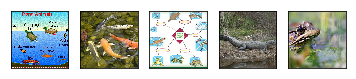

In [39]:
def show_images(image_path_list):
    plt.figure()
    for i, image_path in enumerate(image_path_list):
        plt.subplot(1, len(image_path_list), i+1)
        plt.imshow(np.asarray(Image.open(image_path)))
        #plt.title(image_path)
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
    plt.show()
    
show_images([img1,img2,img3,img4,img5])

## Part 3 - AutoML

Use [TPOT](https://github.com/EpistasisLab/tpot) to fit a predictive model for the King County housing data, with `price` as the target output variable.

In [40]:
!pip install tpot

    100% |████████████████████████████████| 81kB 3.1MB/s 
    100% |████████████████████████████████| 942kB 20.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
Successfully built stopit deap


In [41]:
!wget https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv

--2019-04-12 16:27:02--  https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2515206 (2.4M) [text/plain]
Saving to: ‘kc_house_data.csv’

kc_house_data.csv   100%[===================>]   2.40M  --.-KB/s    in 0.09s   

2019-04-12 16:27:02 (27.6 MB/s) - ‘kc_house_data.csv’ saved [2515206/2515206]



In [42]:
!head kc_house_data.csv

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
"7129300520","20141013T000000",221900,3,1,1180,5650,"1",0,0,3,7,1180,0,1955,0,"98178",47.5112,-122.257,1340,5650
"6414100192","20141209T000000",538000,3,2.25,2570,7242,"2",0,0,3,7,2170,400,1951,1991,"98125",47.721,-122.319,1690,7639
"5631500400","20150225T000000",180000,2,1,770,10000,"1",0,0,3,6,770,0,1933,0,"98028",47.7379,-122.233,2720,8062
"2487200875","20141209T000000",604000,4,3,1960,5000,"1",0,0,5,7,1050,910,1965,0,"98136",47.5208,-122.393,1360,5000
"1954400510","20150218T000000",510000,3,2,1680,8080,"1",0,0,3,8,1680,0,1987,0,"98074",47.6168,-122.045,1800,7503
"7237550310","20140512T000000",1.225e+006,4,4.5,5420,101930,"1",0,0,3,11,3890,1530,2001,0,"98053",47.6561,-122.005,4760,101930
"1321400060","20140627T000000",257500,3,2.25,1715,6819,"2",0,0,3,7,1715,0,1995,0,"98003",47.3097,-122.327,2238,6819
"2

In [50]:
import pandas as pd
from tpot import TPOTRegressor

df = pd.read_csv('kc_house_data.csv')

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [0]:
from sklearn.model_selection import train_test_split

X = df.drop(['price','date'], axis=1).values
X = X.astype(np.float64)

y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size = 0.25)


In [53]:
%%time

tpot = TPOTRegressor(generations=1, population_size=5, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Generation 1 - Current best internal CV score: -16665228760.765759

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.75, learning_rate=0.1, loss=ls, max_depth=7, max_features=0.55, min_samples_leaf=10, min_samples_split=14, n_estimators=100, subsample=0.45)
-15084592055.941854
CPU times: user 6min 24s, sys: 2.24 s, total: 6min 27s
Wall time: 6min 24s


As with previous questions, your goal is to run TPOT and successfully run and report error at the end.  Also, in the interest of time, feel free to choose small `generation=1` and `population_size=10` parameters so your pipeline runs efficiently and you are able to iterate and test.

*Hint* - you'll have to drop and/or type coerce at least a few variables to get things working. It's fine to err on the side of dropping to get things running, as long as you still get a valid model with reasonable predictive power.

In [0]:
# TODO - your code!

## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- What do you consider your strongest area, as a Data Scientist?
- What area of Data Science would you most like to learn more about, and why?
- Where do you think Data Science will be in 5 years?

A few sentences per answer is fine - only elaborate if time allows.

Thank you for your hard work, and congratulations! You've learned a lot, and should proudly call yourself a Data Scientist.

I consider my strongest area to be predictive modeling. I think I have had the most practice with this. Things like logistic regression, random forest classifier, and neural nets are fun, interesting, and I have the most experience with them.


I'd like to most learn about Deep Learning. I think it's fascinating that computers are able to learn and produce materials that humans would take months if not years to figure out.


I think data science will be more automated in 5 years. Models will be easier to be used by other people, but still not so easy that having a Data Science in the company is out of the question.